In [2]:
%matplotlib inline
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from process import *

# load in data
data_path='../data_extraction/data/'

cohort = pd.read_table(data_path+'cohort.tsv')

cohort.ix[cohort.age > 90, 'age']=90

urine = pd.read_csv(data_path+'urine.csv')
urine = urine.loc[urine['value'] < 5000]

maps = pd.read_csv(data_path+'map.csv')
creatinine = pd.read_csv(data_path+'creatinine.csv')
admission_creatinine = pd.read_csv(data_path+'admission_creatinine.csv')


In [3]:
# Interpolate the weights

cohort.set_index('icustay_id', inplace=True)

cohort = interpolateweights(cohort)

# Compute the urine blocks
aki_urine = calculateurineaki(urine, cohort)
cohort = pd.read_table(data_path+'cohort.tsv')

In [4]:
# Get ethnicities 
eth = geteth(cohort)

In [5]:
# clean the lactate
cohort = cohort.loc[cohort['max_lactate'] < 100]
cohort = cohort[pd.notnull(cohort['max_lactate'])]

In [6]:
# Get map features 
mean_maps, min_maps, map_fracs = getmapfeatures(maps)

Fraction of hours missing MAP values: 0.0739482307313


In [7]:
# Process creatinine values and calculate aki 
creat_summary = analyzecreatinine(creatinine, admission_creatinine)

In [8]:
# Get the logistic regression data
lr_data, aki_dataset, non_aki_dataset = getlrdata(cohort, eth, min_maps, creat_summary, aki_urine)

In [9]:
# Summarize results

#AKI
print "------------------------------- AKI Patients -------------------------------"
print "============================================================================"
get_summary(aki_dataset)

#Non-AKI
print "----------------------------- Non-AKI Patients -----------------------------"
print "============================================================================"
get_summary(non_aki_dataset)

#Overall
print "------------------------------- All Patients -------------------------------"
print "============================================================================"
get_summary(lr_data)

------------------------------- AKI Patients -------------------------------
               age          los  max_lactate    vaso_frac      min_map
count  2326.000000  2326.000000  2326.000000  2326.000000  2326.000000
mean     74.864777    13.061265     3.154321     0.150059    56.711542
std      52.612659    11.373221     2.694477     0.221234     8.766882
min      18.440591     3.001000     0.600000     0.000000    31.000000
25%      53.801045     5.560975     1.500000     0.000000    52.000000
50%      66.764063     9.568150     2.200000     0.034030    56.277751
75%      77.871133    16.282825     3.800000     0.228574    62.000000
max     309.777981   173.072500    27.700000     0.995077    88.000000

gender:
F    1186
M    1140
dtype: int64

F    0.509888
M    0.490112
dtype: float64

ethnicity:
WHITE                            1748
UNKNOWN                           264
BLACK/AFRICAN AMERICAN            154
HISPANIC/LATINO                    67
MULTI/OTHER                       

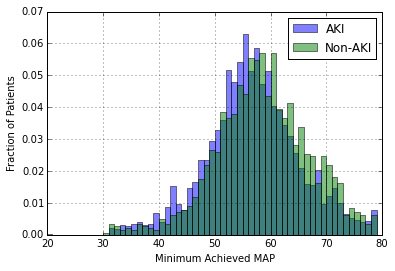

In [10]:
# Look at MAP split between AKI and Non-AKI subsets
bins = np.arange(20,80,1)

aki_dataset['min_map'].hist(alpha=0.5, bins = bins, label='AKI',normed=True)
non_aki_dataset['min_map'].hist(alpha=0.5, bins = bins, label='Non-AKI',normed=True)

plt.legend(loc='upper right')
plt.xlabel('Minimum Achieved MAP')
plt.ylabel('Fraction of Patients')
plt.show()

In [13]:
# Organize data for logistic regression

train_cols = lr_data[['age','gender','eth','los','max_lactate','vaso_frac','min_map_bin']]
train_cols['gender'] = pd.Categorical(train_cols['gender'])
train_cols['eth'] = pd.Categorical(train_cols['eth'])
train_cols['min_map_bin'] = pd.Categorical(train_cols['min_map_bin'])

train_cols['gender'] = train_cols.gender.cat.codes
train_cols['eth'] = train_cols.eth.cat.codes
train_cols['min_map_bin'] = train_cols.min_map_bin.cat.codes

# Manually add the intercept
train_cols['intercept'] = 1.0

# Do logistic regression
logit = sm.Logit(lr_data['aki'], train_cols)
result = logit.fit()
print result.summary()

Optimization terminated successfully.
         Current function value: 0.627266
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    aki   No. Observations:                 3773
Model:                          Logit   Df Residuals:                     3765
Method:                           MLE   Df Model:                            7
Date:                Wed, 07 Dec 2016   Pseudo R-squ.:                 0.05782
Time:                        09:15:26   Log-Likelihood:                -2366.7
converged:                       True   LL-Null:                       -2511.9
                                        LLR p-value:                 6.566e-59
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
age             0.0038      0.001      4.547      0.000         0.002     0.005
gender         -0.0831    

In [117]:
# Get odds ratios
print np.exp(result.params)

age                1.003764
gender             0.920236
eth                1.069603
los                1.063153
max_lactate        1.039724
vaso_frac          1.562717
min_map_bin_num    0.833724
intercept          0.595016
dtype: float64
